# FaceSigns Watermark Testing & Analysis 

In [1]:
import torch
import os
from IPython.display import clear_output
import torch.nn.functional as F
import PIL.Image
from io import BytesIO
import IPython.display
import numpy as np
import skimage.io
import image_transforms

from zipfile import ZipFile

# Set Variables

In [2]:
img_dir = "sample_images"

working_dir = str(Path.cwd()) 
img_dir = working_dir + '\\sample_images\\celeba_data.zip'

target_image_dir = "sample_target_images"
out_dir = "out_dir"
encoder_model_path = "encoder_model.pth"
decoder_model_path = "decoder_model.pth"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Models

In [3]:
encoder_model = torch.jit.load("encoder_model.pth", map_location=torch.device('cpu'))
decoder_model = torch.jit.load("decoder_model.pth", map_location=torch.device('cpu'))
encoder_model.eval().to(device)
decoder_model.eval().to(device)
clear_output()

In [4]:
def showarray(a, fmt='png'):
    """
    takes a numpy array (0 to 1) of size h, w, 3
    """
    a = np.uint8(a*255.)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    
def text_to_bits(text, encoding='utf-8', errors='surrogatepass'):
    bits = bin(int.from_bytes(text.encode(encoding, errors), 'big'))[2:]
    return bits.zfill(8 * ((len(bits) + 7) // 8))

def text_from_bits(bits, encoding='utf-8', errors='surrogatepass'):
    n = int(bits, 2)
    return n.to_bytes((n.bit_length() + 7) // 8, 'big').decode(encoding, errors) or '\0'

def load_images(image_filepaths, img_size=256):
    i = 0 
    print("Loading images")
    image_batch_np = []
    for file_path in image_filepaths:
        if (i % 100 == 0):
            print(i)
        image_from_file = skimage.io.imread(file_path)/255.0
        
        image_from_file = skimage.transform.resize(image_from_file, (300,300),
                                                   preserve_range=True, mode='constant')
        
        image_from_file = image_from_file[:, :, :3]


        image_batch_np.append(image_from_file)
        i = i + 1
    image_batch_np = np.stack(image_batch_np, axis=0)
    image_batch = torch.from_numpy(image_batch_np).float()
    image_batch = image_batch.permute(0, 3, 1, 2)

    h, w = image_batch.shape[2:]
    if h > w:
        image_batch = image_batch[:, :, int((h-w)/2):int((h+w)/2), :]
    elif w > h:
        image_batch = image_batch[:, :, :, int((w-h)/2):int((w+h)/2)]
    image_batch = F.interpolate(image_batch, size=(img_size, img_size), mode='bilinear', align_corners=True)

    return image_batch

def save_images(image_batch, out_dir, prefix=""):
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    
    image_paths = []
    for img_idx in range(image_batch.shape[0]):
        image_np = image_batch[img_idx].permute(1, 2, 0).cpu().numpy()
        image_np = np.uint8(image_np*255.)
        file_path = os.path.join(out_dir, "{}_{}.png".format(prefix, img_idx))
        PIL.Image.fromarray(image_np).save(file_path)
        image_paths.append(file_path)
    
    return image_paths

def find_image_paths(image_dir):
  
    image_paths = []

    if image_dir == "sample_images" or image_dir == "alternate_deepfakes" or image_dir == "sample_target_images":
        for img_file in os.listdir(image_dir):
            if img_file.endswith(".png") or img_file.endswith(".jpg"):
                image_paths.append(os.path.join(image_dir, img_file))
    else:
        with ZipFile(img_dir) as zip_archive: 
            for img_file in zip_archive.filelist:
                image_paths.append(os.path.join(image_dir, img_file.filename))
    
    image_paths.sort()
    return image_paths

def decode_images(image_paths, secret_numpy, decoder_model):
    image_batch = load_images(image_paths)
    with torch.no_grad():
        image_batch = image_batch.to(device)
        decoded_secrets, _ = decoder_model(image_batch)

    predicted_secrets = (F.sigmoid(decoded_secrets) > 0.5).long()
    secrets = torch.from_numpy(secret_numpy).repeat(predicted_secrets.shape[0], 1).to(device) 
    secret_accuracy = (predicted_secrets == secrets).float().mean().item()

    decoding_results = []
    for img_idx, image_path in enumerate(image_paths):
        image_predicted_secret = predicted_secrets[img_idx].cpu().numpy().tolist()
        image_predicted_secret_bits = "".join([str(b) for b in image_predicted_secret][:secrete_num_bits])
        try:
            image_predicted_secret_text = text_from_bits(image_predicted_secret_bits)
        except:
            image_predicted_secret_text = "could not decode"
        
        decoding_results.append({
            "image_path": image_path,
            "image_predicted_secret_text": image_predicted_secret_text,
            "bit_accuracy": (predicted_secrets[img_idx] == secrets[img_idx]).float().mean().item()
        })
    
    return secret_accuracy, decoding_results

In [5]:
working_dir = str(Path.cwd()) 
img_dir = working_dir + '\\sample_images\\celeba_data.zip'

# Set Watermark 'secret' value

In [6]:
# convert text to secret bits
secret_text = "sample"
secret_size = 128
secret_bits = text_to_bits(secret_text)
secrete_num_bits = len(secret_bits)

assert secrete_num_bits <= secret_size

secret_bits = secret_bits + "".join(["0"]*(secret_size-secrete_num_bits))   #Pad secret bits with zeroes until 128bits
secret_numpy = np.array([[ int(c) for c in  secret_bits ]])                #Convert to array 

# Load Images

Change value here to load more images 

In [7]:
original_image_paths = find_image_paths(img_dir) #returns image path that has all images 
original_image_paths = original_image_paths[1000:1500]

images = load_images(original_image_paths)
images = images.to(device)
secrets = torch.from_numpy(secret_numpy).repeat(images.shape[0], 1).to(device)

Loading images
0
100
200
300
400


# Watermark Images

Original Image, Signed Image, Perturbation (Scaled for Visualization)


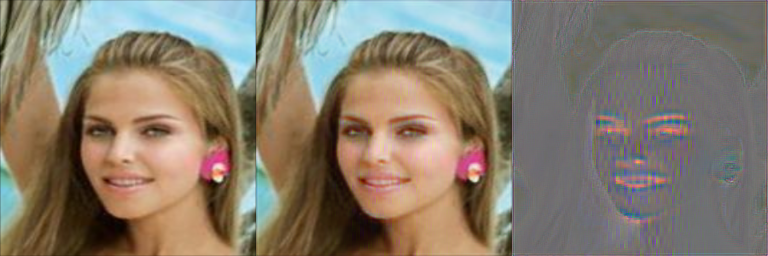

Original Image, Signed Image, Perturbation (Scaled for Visualization)


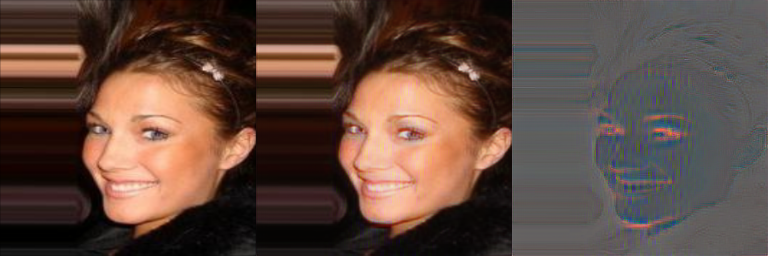

Original Image, Signed Image, Perturbation (Scaled for Visualization)


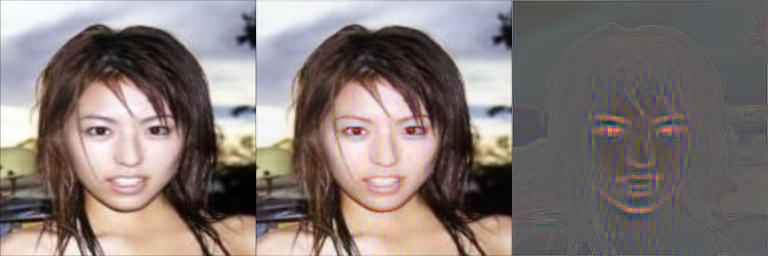

Original Image, Signed Image, Perturbation (Scaled for Visualization)


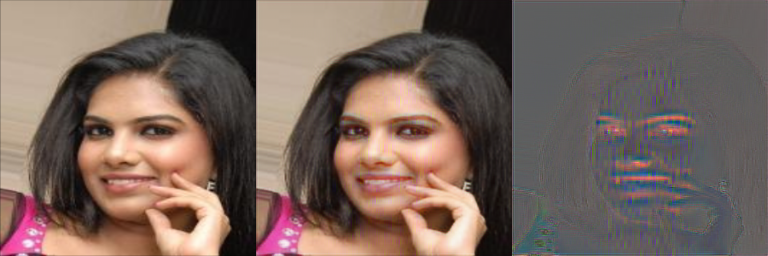

Original Image, Signed Image, Perturbation (Scaled for Visualization)


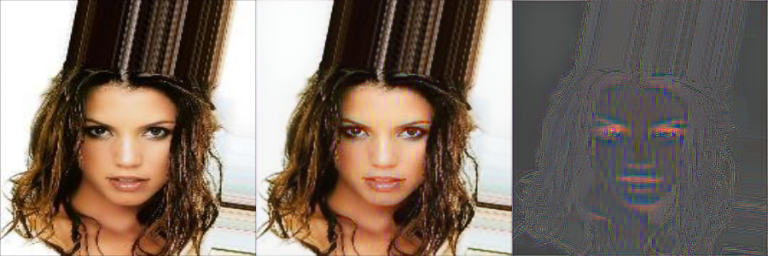

In [8]:
with torch.no_grad():
        
    encoded_images, secret_images = encoder_model(images, secrets)
    signed_image_dir = os.path.join(out_dir, "signed_images")
    encoded_image_paths = save_images(encoded_images, signed_image_dir)


for sidx in range(5):
    original_image_numpy = images[sidx].permute(1, 2, 0).cpu().numpy() 
    encoded_image_numpy = encoded_images[sidx].permute(1, 2, 0).cpu().numpy()
    residual = (encoded_image_numpy - original_image_numpy)
    rmin, rmax = np.min(residual), np.max(residual)
    residual_scaled = (residual-rmin)/(rmax - rmin)
    original_encoded_image = np.concatenate( (original_image_numpy, encoded_image_numpy, residual_scaled), axis=1)
    print("Original Image,", "Signed Image,", "Perturbation (Scaled for Visualization)")
    showarray(original_encoded_image)


# Split Dataset In half

In [9]:
total_images = len(encoded_image_paths)
print('Total Images: ', total_images)

half = int(total_images/2)
benign_encoded_image_paths = encoded_image_paths[:half]
mal_encoded_image_paths = encoded_image_paths[half:]

print('Benign Transformations: ', len(benign_encoded_image_paths))
print('Malicous Transformations: ', len(mal_encoded_image_paths))


Total Images:  500
Benign Transformations:  250
Malicous Transformations:  250


# Make Benign Transformations

In [11]:
benign_dir = os.path.join(out_dir, "benign_transformed_images")
benign_tranform_list, benign_file_paths = image_transforms.apply_benign_transforms(benign_encoded_image_paths, benign_dir)

Benign Transformation total:  250


# Decode benign Images and classify as Benign or Malicous based on Bit Recovery Accuracy

In [13]:
#For filter in filter list, decode_image 
for key in benign_tranform_list:
    secret_accuracy, decoding_results = decode_images(benign_file_paths[key], secret_numpy, decoder_model)
    
    for row in decoding_results:
        BRA = row['bit_accuracy']
        if BRA >= 0.95:
            y_pred.append(1)
        else:
            y_pred.append(0)
    

Loading images
0
100
200


C:\Users\Odyss\PycharmProjects\deepfake_watermarking\venv\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Loading images
0
100
200
Loading images
0
100
200
Loading images
0
100
200
Loading images
0
100
200


### Display Example Benign Transformation

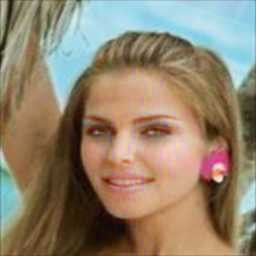

Transform : JPEG-50
Predicted secret: sample
Bit accuracy: 0.984375
Image path: out_dir\benign_transformed_images\_0.png_JPEG-50.jpeg
-----------------------------------------------------



In [14]:
for row in decoding_results[:1]:
        IPython.display.display(IPython.display.Image(row['image_path']))
        print("Transform : {}".format(key))
        print("Predicted secret: {}".format(row['image_predicted_secret_text']))
        print("Bit accuracy: {}".format(row['bit_accuracy']))
        print("Image path: {}".format(row['image_path']))
        print ("-----------------------------------------------------\n")

In [ ]:
for row in decoding_results[:1]:
        IPython.display.display(IPython.display.Image(row['image_path']))
        print("Transform : {}".format(key))
        print("Predicted secret: {}".format(row['image_predicted_secret_text']))
        print("Bit accuracy: {}".format(row['bit_accuracy']))
        print("Image path: {}".format(row['image_path']))
        print ("-----------------------------------------------------\n")

# Make Malicous Tranformations

## FaceSwap Algorithm 
Is unable to swap faces when the sample image is not a face-forward picture

In [16]:
mal_dir = os.path.join(out_dir, "mal_transformed_images")
target_image_paths = find_image_paths(target_image_dir)

unable_to_malicously_swap, mal_tranform_list, mal_file_paths = image_transforms.apply_malicious_transforms(
    mal_encoded_image_paths, target_image_paths[1:2], mal_dir)

Error in shallowfakes
Error in shallowfakes
Error in shallowfakes
Error in shallowfakes
Error in shallowfakes
Error in shallowfakes
Error in shallowfakes
Error in shallowfakes
Error in shallowfakes
Error in shallowfakes
Error in shallowfakes
Error in shallowfakes
Error in shallowfakes
Error in shallowfakes
Error in shallowfakes
Error in shallowfakes
Error in shallowfakes
Error in shallowfakes
Error in shallowfakes


In [17]:
unable_to_malicously_swap

19

# Decode malicous Images and classify as Benign or Malicous based on Bit Recovery Accuracy

In [18]:
for key in mal_tranform_list:
    secret_accuracy, decoding_results = decode_images(mal_file_paths[key], secret_numpy, decoder_model)
        
    for row in decoding_results:
        BRA = row['bit_accuracy']
        if BRA >= 0.95:
            y_pred.append(1)
        else:
            y_pred.append(0)  
            """
            if BRA > 0.50:
                print("Transform : {}".format(key))
                print("Predicted secret: {}".format(row['image_predicted_secret_text']))
                print("Bit accuracy: {}".format(row['bit_accuracy']))
                IPython.display.display(IPython.display.Image(row['image_path']))
                print ("-----------------------------------------------------\n")
            """

Loading images
0
100
200


In [20]:
# Adjust length to the images that were able to be swapped. 
if(unable_to_malicously_swap): 
    l = len(y_actual) - unable_to_malicously_swap 
    y_actual = y_actual[:l]
    print(len(y_actual))

1481


### Display Example Malcious Transformation

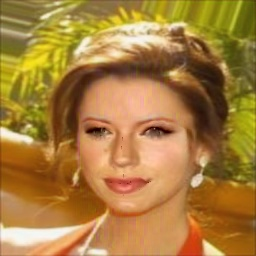

Transform : face_swap
Predicted secret: could not decode
Bit accuracy: 0.5
-----------------------------------------------------



In [31]:
for row in decoding_results[23:24]:
    IPython.display.display(IPython.display.Image(row['image_path']))
    print("Transform : {}".format(key))
    print("Predicted secret: {}".format(row['image_predicted_secret_text']))
    print("Bit accuracy: {}".format(row['bit_accuracy']))
    print ("-----------------------------------------------------\n")

# Analyze Watermark Method

In [22]:
print(len(y_pred))
print(len(y_actual))

1481
1481


In [23]:
assert(len(y_pred) == len(y_actual))

In [24]:
pred = y_pred 
actual = y_actual

### AUC

In [25]:
import numpy as np
from sklearn import metrics

pred = y_pred
actual = y_actual 

auc = metrics.roc_auc_score(actual, pred)
auc

0.9984

### Confusion Matrix

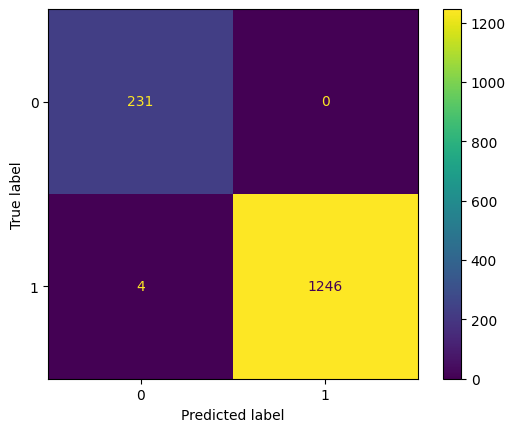

In [26]:
import matplotlib.pyplot as plt

import numpy as np 
from sklearn import metrics 

confusion_matrix = metrics.confusion_matrix(actual, pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix) #, display_labels = [False, True]
cm_display.plot()
plt.show()
